In [1]:
#Make the notebook fill the browser window
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Libs section

In [2]:
#Data libraries
import pandas as pd
import numpy as np

#Graph libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Risky')
green_patch = mpatches.Patch(color='green', label='Safe')
blue_patch = mpatches.Patch(color='blue', label='price (USDT)')
import seaborn as sns

#Preprocessing libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

#LSTM libraries
#import tensorrt
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, GRU, Bidirectional, Dense

from tensorflow.keras.optimizers import Adam, Nadam, AdamW
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


2023-06-28 21:24:10.132104: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-28 21:24:10.160700: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 21:24:10.601888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Constants section

In [3]:
NEW_MODEL = True
WINDOW_SIZE = 4
MODEL_NAME = "BTC-PRDICTION-1"

#### Loading dataset

In [4]:
data = pd.read_csv("src/data.csv")

#Convert timestamp to datetime format
formattedTime = pd.to_datetime(data["timestamp"],unit='ms').dt.strftime("%d %m",)

#### Dataset analysis

In [5]:
#EXCLUIR
data = data.head(5000)

In [6]:
missing_counts = data.isnull().sum()
print("Missing data:")
print(missing_counts)
print("dataset shape: ", data.shape)    

Missing data:
timestamp      0
volumeRisky    0
volumeSafe     0
tradesRisky    0
tradesSafe     0
price          0
dtype: int64
dataset shape:  (5000, 6)


#### Graphical analysis

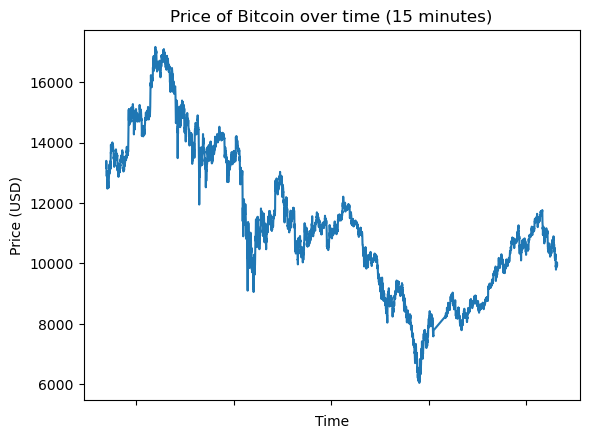

In [7]:

ax = sns.lineplot(x=data["timestamp"], y=data["price"]).set(title='Price of Bitcoin over time (15 minutes)', xlabel='Time', ylabel='Price (USD)', xticklabels=[])

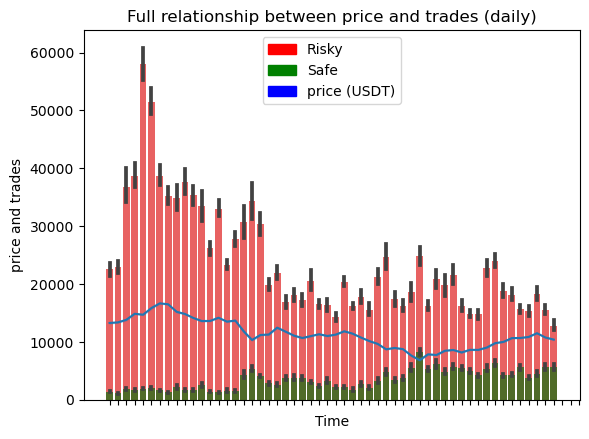

In [8]:
#ax=plt.subplots()
ax=sns.barplot(x=formattedTime, y=data["tradesRisky"], color="red",alpha=0.7)
ax=sns.barplot(x=formattedTime, y=data["tradesSafe"], color="green",alpha=0.7)
ax = sns.lineplot(x=formattedTime, y=data["price"])
ax.set(title='Full relationship between price and trades (daily)', xlabel='Time', ylabel='price and trades',xticklabels=[])
ax.legend(handles=[red_patch,green_patch,blue_patch])

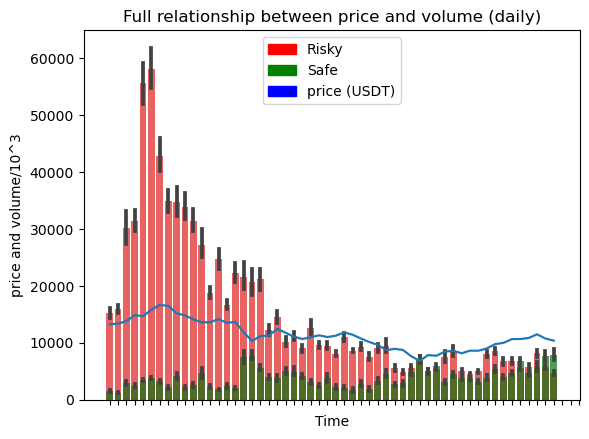

In [9]:
ax=plt.subplots()
ax=sns.barplot(x=formattedTime, y=data["volumeRisky"]/(10**3), color="red",alpha=0.7)
ax=sns.barplot(x=formattedTime, y=data["volumeSafe"]/(10**3), color="green",alpha=0.7)
ax = sns.lineplot(x=formattedTime, y=data["price"])
ax.set(title='Full relationship between price and volume (daily)', xlabel='Time', ylabel='price and volume/10^3',xticklabels=[])
ax.legend(handles=[red_patch,green_patch,blue_patch])

Text(0.5, 1.08, 'Pairplot of all variables')

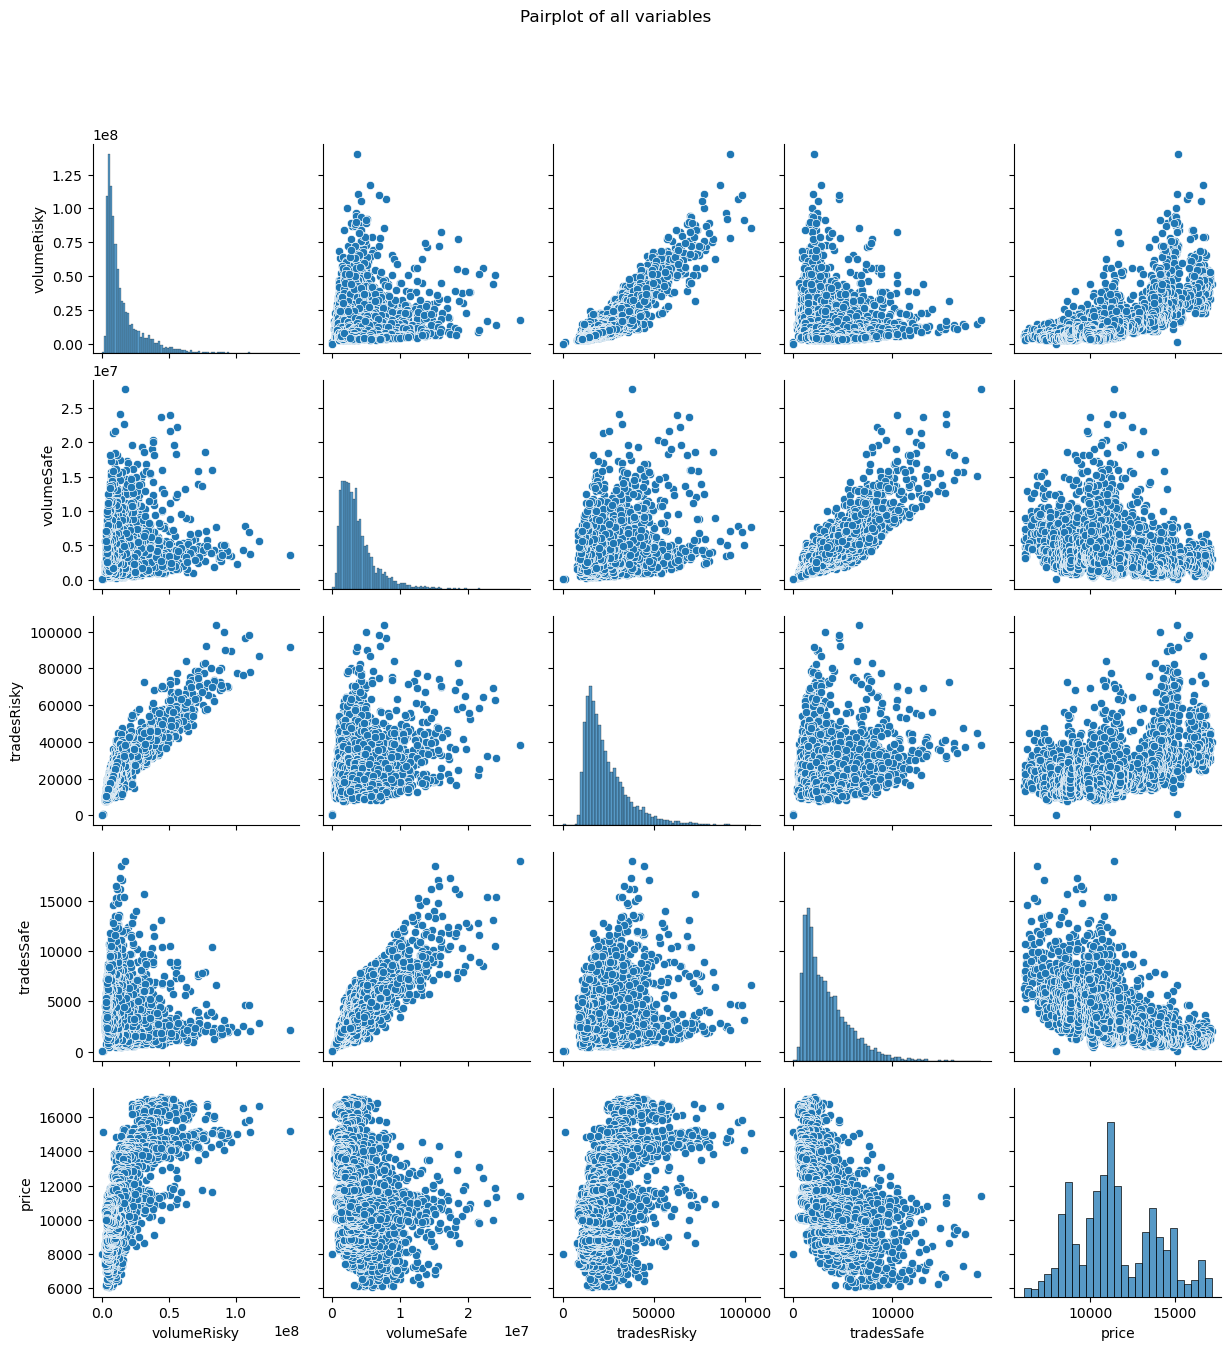

In [10]:

ax = sns.pairplot(data.drop(data.columns[[0]], axis=1))
ax.fig.suptitle("Pairplot of all variables", y=1.08)


#### Preprocessing data

In [11]:
data_scaled = data.copy()
data_scaled.drop('timestamp', axis=1, inplace=True)

#scaler inputs
scaler_volrisk = MinMaxScaler(feature_range=(0,1))
scaler_volsafe = MinMaxScaler(feature_range=(0,1))
scaler_traderisk = MinMaxScaler(feature_range=(0,1))
scaler_tradesafe = MinMaxScaler(feature_range=(0,1))
scaler_price = MinMaxScaler(feature_range=(0,1))

volrisk_scaled = np.array(data["volumeRisky"]).copy()
volsafe_scaled = np.array(data["volumeSafe"]).copy()
traderisk_scaled = np.array(data["tradesRisky"]).copy()
tradesafe_scaled = np.array(data["tradesSafe"]).copy()
price_scaled = np.array(data["price"]).copy()

data_scaled['volumeRisky'] = scaler_volrisk.fit_transform(volrisk_scaled.reshape(-1,1)).flatten()
data_scaled['volumeSafe'] = scaler_volsafe.fit_transform(volsafe_scaled.reshape(-1,1)).flatten()
data_scaled['tradesRisky'] = scaler_traderisk.fit_transform(traderisk_scaled.reshape(-1,1)).flatten()
data_scaled['tradesSafe'] = scaler_tradesafe.fit_transform(tradesafe_scaled.reshape(-1,1)).flatten()
data_scaled['price'] = scaler_price.fit_transform(price_scaled.reshape(-1,1)).flatten()

In [12]:
data_scaled

,volumeRisky,volumeSafe,tradesRisky,tradesSafe,price
0,0.163938,0.094036,0.308127,0.122857,0.639609
1,0.129716,0.054559,0.260873,0.074233,0.660944
2,0.149609,0.063241,0.277111,0.085185,0.645303
3,0.144092,0.083041,0.264074,0.096508,0.621604
4,0.139938,0.056054,0.249606,0.061852,0.615670
...,...,...,...,...,...
4995,0.029131,0.359308,0.126607,0.383757,0.354718
4996,0.034092,0.390897,0.141114,0.388466,0.353786
4997,0.033821,0.404308,0.140127,0.380317,0.347952
4998,0.023640,0.255544,0.100204,0.278677,0.358639


#### Creating time window

In [13]:
x_names = data_scaled.columns.to_list()
y_names = data_scaled.columns[4:5].to_list()


In [14]:
x_frames = []
y_frames = []
for i in range(0, (len(data_scaled) - WINDOW_SIZE)):
    
    x_frame = data_scaled.loc[i:(i+WINDOW_SIZE-1),x_names].to_numpy()
    x_frames.append(x_frame)
    
    y_frame = data_scaled.loc[i+WINDOW_SIZE, y_names].to_numpy()
    y_frames.append(y_frame)

x_frames = np.array(x_frames)
y_frames = np.array(y_frames) 

In [15]:
x_frames[1]

array([[0.12971589, 0.05455857, 0.26087293, 0.0742328 , 0.66094419],
       [0.1496093 , 0.06324136, 0.277111  , 0.08518519, 0.64530315],
       [0.14409192, 0.08304066, 0.26407412, 0.09650794, 0.62160441],
       [0.13993828, 0.05605436, 0.2496059 , 0.06185185, 0.61566961]])

In [16]:
y_frames[2]

array([0.61602897])

In [17]:
x_frames.shape

(4996, 4, 5)

#### Splitting dataset in train and test

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_frames, y_frames, test_size=0.3, shuffle=False)

In [19]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(3497, 4, 5)
(3497, 1)
(1499, 4, 5)
(1499, 1)


#### Model config

In [20]:
#Nurons in each layer
units_lstm1 = 16
units_lstm2 = 32
units_lstm3 = 32
units_dense = 16

#Constants
ACT_FUNC = "tanh"

#inicializador
initializer = tensorflow.keras.initializers.LecunNormal(seed=42)

# Criação das entradas de treino+validação
inputs = Input(shape=(x_frames.shape[1], x_frames.shape[2]), name="x_train")

# Camada LSTM 1
layer_lstm1 = LSTM(units_lstm1, 
                     activation=ACT_FUNC, 
                     return_sequences=True,
                     kernel_initializer=initializer)(inputs)

# Camada LSTM 2
layer_lstm2 = LSTM(units_lstm2, 
                     activation=ACT_FUNC, 
                     return_sequences=True,
                     kernel_initializer=initializer)(layer_lstm1)

# Camada LSTM 3
layer_lstm3 = LSTM(units_lstm3,
                     activation=ACT_FUNC, 
                     return_sequences=False,
                     kernel_initializer=initializer)(layer_lstm2)

# Camada densa final para ajustar o formato da saída
layer_dense = Dense(units_dense, activation=ACT_FUNC)(layer_lstm3)

# Camada densa final para ajustar o formato da saída
layer_dense_out = Dense(y_frames.shape[1], activation=ACT_FUNC)(layer_dense)

# Criação do modelo
model_trained = Model(inputs=inputs, outputs=layer_dense_out)

model_trained.summary()

2023-06-28 21:24:23.244203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-28 21:24:23.262749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-28 21:24:23.262936: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_train (InputLayer)        [(None, 4, 5)]            0         
                                                                 
 lstm (LSTM)                 (None, 4, 16)             1408      
                                                                 
 lstm_1 (LSTM)               (None, 4, 32)             6272      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 16,545
Trainable params: 16,545
Non-trainable p

2023-06-28 21:24:23.967248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 21:24:23.968210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 21:24:23.968770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

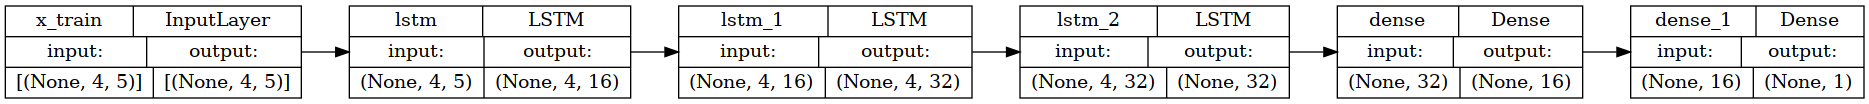

In [21]:
plot_model(model_trained, show_shapes=True, show_layer_names=True, rankdir="LR")

#### Model optimization and checkpoint creation

In [22]:
if (NEW_MODEL == True):
          
    es = EarlyStopping(monitor='loss', mode='min', patience=50)


    cp = ModelCheckpoint(filepath='models/', 
                           save_weights_only=True, 
                           monitor='loss', 
                           mode='min', 
                           save_best_only=True)
    
    #Adamax(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, clipnorm=1)
    #Nadam(learning_rate=0.0001, beta_1=0.85, beta_2=0.989, epsilon=1e-06, clipnorm=1)
    
    opt = Nadam(learning_rate=0.0001, beta_1=0.85, beta_2=0.989, epsilon=1e-06, clipnorm=1)
    
    model_trained.compile(optimizer = opt, loss = 'mean_squared_error')

    history = model_trained.fit(x_train, 
                               y_train, 
                               validation_split=0.2, 
                               epochs=1000, 
                               verbose=1, 
                               callbacks=[cp, es], 
                               batch_size=64, 
                               shuffle=False)
    
    np.save('models/history_model.npy', history.history)
    model_trained.load_weights('models/')
    model_trained.save('models/' + MODEL_NAME)
else:
    model_trained = load_model('models/' + MODEL_NAME)

Epoch 1/1000


2023-06-28 21:24:24.289142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 21:24:24.290276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 21:24:24.290887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

43/44 [============================>.] - ETA: 0s - loss: 0.3060

2023-06-28 21:24:29.733859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 21:24:29.734518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 21:24:29.735154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

44/44 [==============================] - 6s 24ms/step - loss: 0.3029 - val_loss: 0.0396
Epoch 2/1000
44/44 [==============================] - 1s 21ms/step - loss: 0.1529 - val_loss: 0.0077
Epoch 3/1000
44/44 [==============================] - 1s 14ms/step - loss: 0.0606 - val_loss: 0.0026
Epoch 4/1000
44/44 [==============================] - 1s 14ms/step - loss: 0.0233 - val_loss: 0.0091
Epoch 5/1000
44/44 [==============================] - 1s 14ms/step - loss: 0.0129 - val_loss: 0.0140
Epoch 6/1000
44/44 [==============================] - 1s 19ms/step - loss: 0.0102 - val_loss: 0.0147
Epoch 7/1000
44/44 [==============================] - 1s 21ms/step - loss: 0.0093 - val_loss: 0.0133
Epoch 8/1000
44/44 [==============================] - 1s 14ms/step - loss: 0.0086 - val_loss: 0.0114
Epoch 9/1000
44/44 [==============================] - 1s 13ms/step - loss: 0.0080 - val_loss: 0.0096
Epoch 10/1000
44/44 [==============================] - 1s 22ms/step - loss: 0.0075 - val_loss: 0.0080
Ep

2023-06-28 21:35:50.931491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 21:35:50.932026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 21:35:50.932738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: models/BTC-PRDICTION-1/assets


INFO:tensorflow:Assets written to: models/BTC-PRDICTION-1/assets


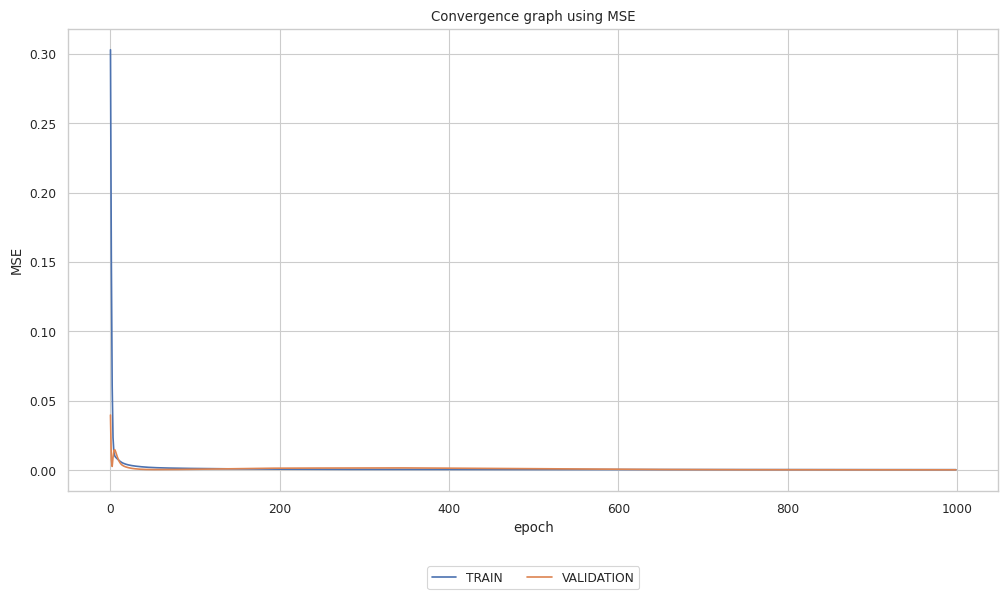

In [23]:
history=np.load('models/history_model.npy', allow_pickle='TRUE').item()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

train_metric = history['loss']
valid_metric = history['val_loss']
name_metric = 'mse'

fig = plt.figure()

plt.plot(train_metric, label='TRAIN'), 
plt.plot(valid_metric, label='VALIDATION')
plt.ylabel(name_metric.upper())
plt.xlabel('epoch')
plt.title('Convergence graph using ' + name_metric.upper())
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)

plt.show()

#### Prediction and evaluation

In [24]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def printRegressionMetrics(y_true, y_pred):
    
    MAPE = mape(y_true, y_pred)
    R2 = metrics.r2_score(y_true, y_pred)
    
    print('MAPE:')
    print(MAPE)
    print('R2:')
    print(R2)

In [25]:
y_hat = model_trained.predict(x_test)

2023-06-28 21:35:55.053202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 21:35:55.053808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 21:35:55.054542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

47/47 [==============================] - 1s 4ms/step


In [26]:
y_train2 = scaler_price.inverse_transform(y_train.flatten().reshape(-1, 1))
y_test2 = scaler_price.inverse_transform(y_test.flatten().reshape(-1, 1))
y_hat2 = scaler_price.inverse_transform(y_hat.flatten().reshape(-1, 1))

In [27]:
printRegressionMetrics(y_test2, y_hat2)

MAPE:
1.6321638077870935
R2:
0.9745546312041986


In [28]:
#cria um data table com os valores reais e preditos
df_forecast = pd.DataFrame()
df_forecast['y_true'] = np.hstack((y_train2.flatten(), y_test2.flatten()))
df_forecast['y_hat'] = np.hstack((y_train2.flatten(), y_hat2.flatten()))

df_forecast.shape

(4996, 2)

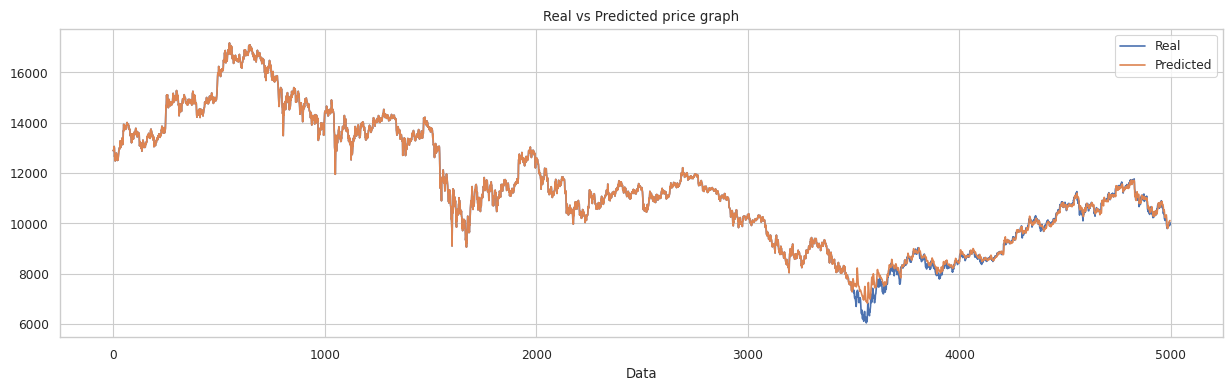

In [29]:
sns.set(rc={'figure.figsize':(15, 4)})
sns.set_style('whitegrid')
sns.set_context('paper')

ax = df_forecast.plot(x_compat=True, style='-')
ax.set_xlabel("Data")
ax.legend(["Real", "Predicted"])
ax.set_title("Real vs Predicted price graph")

plt.grid(True)

plt.show()

plt.close()